# Project Pipeline

## Current Status

Data includes:
- Complete dataset of all the bixi data from all years including station data saved as pickle file
- Station dataset with station list from all years and location information saved as pickle file
- Bike lane data saved as geojson file
- Public transport lines saved as geojson file, list of main public transport station locations as pickle file
- Weather data from 2014 to 2019 saved as .csv files
- Sign data (including speed limits) as .csv file
        
        
Analysis:
- Correlation of bike use with weather (precipitation level, temperature)
- Initial analysis of BIXI data including time evolutions of BIXI use and more detailed station use analysis of 2019 data
- Status of bike stations in 2019 (how many bikes available) based on station caps



## Research Questions

1. Do the trips taken align with existing public transport lines or are they used to fill the gaps of the public transport routes?
2. Are some areas of Montreal more bike-friendly than others (i.e. have bike lanes or are smaller roads) and is this bike friendliness correlated with more trips done in that area?

## Future Tasks

Task 1: General Analysis

1. Correlatin of weather with BIXI system use? How could this affect our results/conclusions? (Ariane)

Task 2: Research Question 1

1. Where are the most used bike stations? (Kiara)
2. Along which paths do people ride the most? (Kiara)
3. What are the most used public transport lines? (base on the schedule, more frequent scheduled buses/metros indicates a more popular line) (Guillaume)
4. Do the most popular paths go between stations on major transport lines? Or are they in areas where there is less public transport (or less efficient transport) available? (Kiara and Guillaume)
5. Visualization of station use on map (folium) (Kiara)

Task 3: Research Question 2

1. Which areas have the highest density of bike lanes in the city? (Quentin)
2. Which areas have a higher density of low speed limit roads? (Ariane)
3. Do the areas with more bike lanes and low speed limits correspond to higher use by the BIXI system? (everyone)
5. Visualization of bike friendliness on map (folium) (Quentin)

Task 4: Final Report

1. Related work (other bike share analysis, other public transport analysis in Montreal)
2. Choose most important data and findings to present
3. Description of important/main methods
4. Organization of data into a 'story'
5. Interactive map of all BIXI station use

Task 5: Poster Presentation

In [3]:
#usefull libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
import folium
from folium import plugins
import re
from haversine import haversine, Unit
from datetime import datetime, date, time
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from collections import namedtuple
import geopandas as gpd
from folium.plugins import HeatMap

# Load saved combined dataframe

In [4]:
#start from here on restart of notebook - loads the combined dataset
#data file needs to be downloaded from https://drive.google.com/open?id=1IZey_n6xR1WtFI03uY69HgJfeBz4_2Lv
#put the data file in the parent directory of the notebook
data = pd.read_pickle("../combined_data")

In [5]:
stations = pd.read_pickle("../stations")

# Time evolution of BIXI use

In [6]:
#station use count
station_use = data.groupby(['year','start_station_code']).size().reset_index(name='counts')
station_use.head()

,year,start_station_code,counts
0,2014,5002,254
1,2014,5003,202
2,2014,5004,187
3,2014,5005,475
4,2014,5006,325


## Number of Stations added each year:

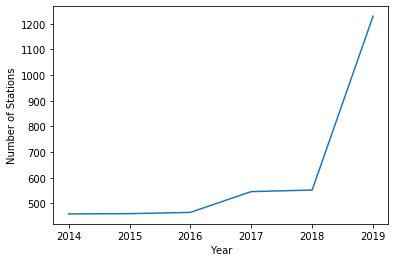

In [8]:
#number of stations
station_count = station_use.groupby('year').size().reset_index(name='num_stat')
plt.plot(station_count.year, station_count.num_stat)
plt.ylabel('Number of Stations')
plt.xlabel('Year')
plt.show()

## Number of trips per year

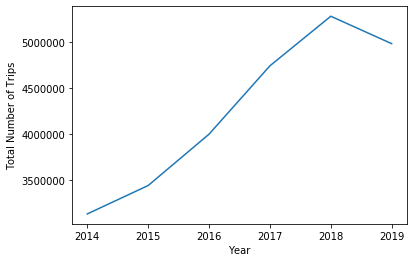

In [9]:
#total number of trips
trips = station_use.groupby('year').sum()
plt.plot(trips.index, trips.counts)
plt.ylabel('Total Number of Trips')
plt.xlabel('Year')
plt.show()

## Use by month:

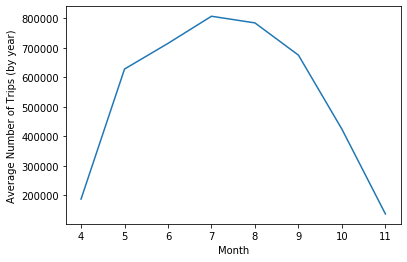

In [10]:
#use by month (averaged over the years)
monthly = data.groupby(['month','year']).size().reset_index(name='trips_per_month')
monthly = monthly[['month','trips_per_month']].groupby('month').mean()
plt.plot(monthly.index, monthly.trips_per_month)
plt.ylabel('Average Number of Trips (by year)')
plt.xlabel('Month')
plt.show()

Note: The bike share system is not available for the months of December to April due to winter conditions

In [14]:
#2019 data only
data19 = data.query('year==2019')

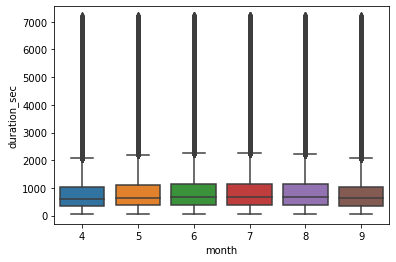

In [13]:
#ride duration by month - 2019
sns.boxplot(x='month', y='duration_sec', data=data19)

## Distance-Duration Relationship:

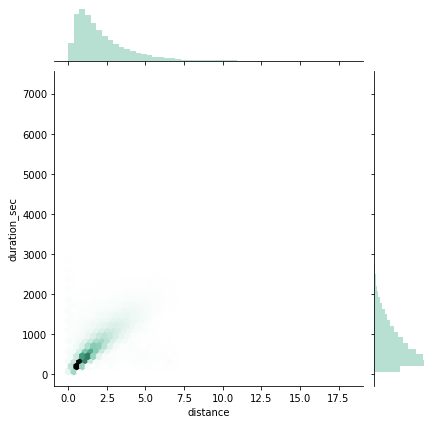

In [14]:
#distance vs duration for 2019 (all months)
sns.jointplot(data19.distance, data19.duration_sec, kind='hex', color="#4CB391")
plt.show()

We can see that most of the trips are short distance and short duration, indicating use for commuting. 

# BIXI use in 2019

## Stations

C:\anaconda\envs\ada\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


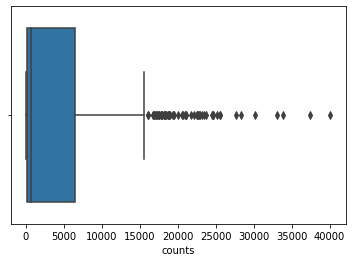

In [43]:
#distribution of station popularity by start of trips from given station
station_use19 = station_use.query('year==2019')
del station_use19['year']
station_use19.drop(station_use19.tail(1).index,inplace=True) #get rid of last row which is not a listed station
station_use19['start_station_code'] = station_use19['start_station_code'].astype('int')

station_use19 = station_use19.merge(stations[['latitude','longitude']], how='left', left_on=['start_station_code'], right_index=True)
sns.boxplot(x=station_use19['counts'])


From this can see that most stations are used less than 15,000 times per year. Now want to list the most frequently used stations (with latitude and longitude so can compare to public transpo) and plot them on a map. 

In [50]:
#create a dataframe with full information on trips from the most popular stations
station_use19_pop = station_use19.query('counts>20000')
popular = data19[data19['start_station_code'].isin(station_use19_pop['start_station_code'])]
popular = popular[['start_station_code','end_station_code','latitude_start','longitude_start','latitude_end','longitude_end','distance']]
pop_stations = popular.groupby('start_station_code')

Representation of only the most used stations. Larger dots indicate more used stations (measured by number of trips starting from the station):

In [75]:
#visualize stations on map
montreal = [45.5017, -73.5673]

m = folium.Map(location=montreal, tiles='Stamen Terrain', zoom_start=12)
for lat, lng, name, count in zip(station_use19_pop.latitude, station_use19_pop.longitude, station_use19_pop.start_station_code, station_use19_pop.counts):
    m.add_child(folium.CircleMarker(location=[lat,lng], fill='true', radius=count/10000, popup=name, fill_color='red', color='red')) #CircleMarker gives dot, Marker gives drop    
m

Heatmap of use of all stations (also measured by number of trips starting from the station):

In [76]:
#station popularity as a heatmap
hm = folium.Map(location=montreal, tiles='Stamen Toner', zoom_start=12)
HeatMap(data=station_use19[['latitude', 'longitude', 'counts']], radius=8, max_zoom=13).add_to(hm)
hm

## Trips (which stations travelling between)

Now we want to look at not just station popularity but path popularity:

In [77]:
#create new index that is 'station_startStation_end'
paths = popular.groupby(['start_station_code','end_station_code']).size().reset_index(name='counts')
paths = paths.merge(popular.drop_duplicates(), how='left', on=['start_station_code','end_station_code'])
paths.head()

,start_station_code,end_station_code,counts,latitude_start,longitude_start,latitude_end,longitude_end,distance
0,6012,4000,65,45.51066,-73.56497,45.549457,-73.541649,4.680953
1,6012,4001,1,45.51066,-73.56497,45.502629,-73.527750,3.034886
2,6012,4002,15,45.51066,-73.56497,45.506194,-73.569968,0.631100
3,6012,5002,1,45.51066,-73.56497,45.533200,-73.515600,4.590819
4,6012,5003,2,45.51066,-73.56497,45.529400,-73.517800,4.224679


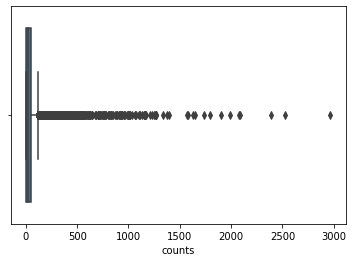

In [78]:
sns.boxplot(x=paths['counts'])

In [79]:
vis = paths.query('counts>1200')

#plot lines between the stations according to number of trips taken
for index, row in vis.iterrows():
    folium.PolyLine([[row.latitude_start,row.longitude_start],[row.latitude_end,row.longitude_end]], color="green", weight=row['counts']/500).add_to(m) 

filt = vis[~vis['end_station_code'].isin(popular['start_station_code'])]
for lat, lng, name in zip(filt.latitude_end,filt.longitude_end,filt.end_station_code):
    m.add_child(folium.CircleMarker(location=[lat,lng], fill='true', radius=2, popup=name, fill_color='blue', color='blue'))
    
m

This shows the most frequent trips taken only, for the final report arrows will be added to show the direction as well. 

# Visualisation
## Bike Paths

The objective is to obtain a heat map of the distribution of bicycle lines in Montreal. To do this, we will already remove lines that do not belong to the City of Montreal from the dataset.

In [80]:
fname = "./BikePaths/reseau_cyclable_2018_c.geojson"

bp = gpd.read_file(fname)

print(type(bp))

bp.head(4)

<class 'geopandas.geodataframe.GeoDataFrame'>


,ID,ID_TRC_GEO,TYPE_VOIE,TYPE_VOIE2,LONGUEUR,NBR_VOIE,SEPARATEUR,SAISONS4,PROTEGE_4S,Ville_MTL,NOM_ARR_VI,geometry
0,8998.0,1230109.0,4.0,0.0,90.0,2.0,M,OUI,OUI,OUI,Le Plateau-Mont-Royal,MULTILINESTRING Z ((-73.59024 45.53259 0.00000...
1,2.0,0.0,5.0,0.0,20.0,2.0,None,NON,NON,OUI,Rivi�re-des-Prairies�Pointe-aux-Trembles,MULTILINESTRING Z ((-73.49679 45.69574 0.00000...
2,3.0,1623974.0,1.0,0.0,36.0,2.0,None,NON,NON,OUI,Rivi�re-des-Prairies�Pointe-aux-Trembles,MULTILINESTRING Z ((-73.57345 45.65853 0.00000...
3,4.0,1010521.0,3.0,31.0,46.0,1.0,None,NON,NON,OUI,Ahuntsic-Cartierville,MULTILINESTRING Z ((-73.71793 45.53550 0.00000...


In [81]:
print(bp.Ville_MTL.unique())

['OUI' 'NON']


In [82]:
bp = bp[bp['Ville_MTL']=='OUI']

In [83]:
print(bp.Ville_MTL.unique())

['OUI']


In [84]:
bp = bp.reset_index(drop=True)

In [85]:
mean_length = bp.LONGUEUR.mean()
print("The average length of bicycle lines is ", mean_length, " m")

The average length of bicycle lines is  133.49512324880297  m


In [86]:
count = 0
for k in range(len(bp['geometry'])):
    for l in range(len(bp['geometry'][k])):
        count+=len(bp['geometry'][k][l].xy[0])
print("Overal number of points :", count)

Overal number of points : 26204


In [87]:
data_pointsx = np.array([])
data_pointsy = np.array([])
for k in range(len(bp['geometry'])):
    for l in range(len(bp['geometry'][k])):
        data_pointsx = np.append(data_pointsx, bp['geometry'][k][l].xy[1])
        data_pointsy = np.append(data_pointsy, bp['geometry'][k][l].xy[0])
data_points = np.vstack((data_pointsx, data_pointsy)).T 

In [88]:
geo_json_data = json.load(open("./BikePaths/reseau_cyclable_2018_c.geojson"))

In [89]:
m_bike = folium.Map([45.53,-73.666], tiles='cartodbpositron', zoom_start=11)
HeatMap(data_points).add_to(m_bike)


m_bike.save("results/desity_bike.html")

In [90]:
%%HTML
<iframe width="100%" height="350" src="results/desity_bike.html"></iframe>

In [91]:
folium.GeoJson(geo_json_data).add_to(m_bike)
m_bike.save("results/density_with_roads_bike.html")

In [92]:
%%HTML
<iframe width="100%" height="350" src="results/density_with_roads_bike.html"></iframe>

## Bus paths

In [93]:
fname = "./BusLines/stm_lignes_sig.shp"

busl = gpd.read_file(fname)

print(type(busl))

busl.head(4)

<class 'geopandas.geodataframe.GeoDataFrame'>


,route_id,headsign,route_name,shape_id,service_id,geometry
0,1,STATION ANGRIGNON,verte,11072,20J,"LINESTRING (302040.087 5050741.446, 301735.980..."
1,1,STATION HONORÉ-BEAUGRAND,verte,11071,20J,"LINESTRING (296733.669 5034064.602, 297506.817..."
2,2,STATION CÔTE-VERTU,orange,20236,20J,"LINESTRING (287432.768 5046526.781, 288453.790..."
3,2,STATION HENRI-BOURASSA,orange,20239,20J,"LINESTRING (290521.096 5041607.071, 291141.889..."


To better understand the different types of transport we have to do in this dataset, it is useful to study the names of the lines.

In [94]:
print(busl.route_name.unique())

['verte' 'orange' 'jaune' 'bleue' 'De Lorimier'
 'Parc-du-Mont-Royal / Ridgewood' 'Île-des-Soeurs' 'Christophe-Colomb'
 'Atateken' 'Sainte-Catherine' 'Graham' 'Décarie' 'Beaubien'
 'Chabanel / Marché Central' 'Place du Commerce' 'Notre-Dame' 'Sherbrooke'
 'Angus' 'Mercier-Est' 'Boulevard Saint-Joseph' 'Honoré-Beaugrand'
 'Rachel' 'Saint-Denis / Saint-Hubert' 'Saint-Denis' 'Lacordaire'
 'Langelier' 'Griffintown' 'Monk' 'Jolicoeur' 'Des Grandes-Prairies'
 'Henri-Bourassa-Est' 'Quartier Saint-Michel / Ahuntsic' 'Monselet'
 'Armand-Bombardier' 'Papineau' 'Casgrain' 'Masson' 'Perras'
 'Maurice-Duplessis' 'Édouard-Montpetit' 'de Liège' 'Charland / Chabanel'
 'Boulevard Saint-Laurent' 'Saint-Hubert' 'Pointe-Saint-Charles'
 'Wellington' 'Girouard' 'Grenet' 'The Boulevard' 'Saint-Michel'
 'Pierrefonds' 'Gouin' 'Bois-Franc' 'Du Centre' 'Alfred-Nobel' 'Dalton'
 'Bridge' 'De la Commune' 'McArthur' 'Station Lionel-Groulx / CUSM'
 'Laurendeau' 'Avenue du Parc' 'Saint-Jean-Baptiste' 'Hochelaga'
 'Poi

We see that there are first the metro lines, designated by colours, then the classic bus lines, then the "Navette Or" and "Express" bus lines.

### Metro lines

In [95]:
m_bus = folium.Map([45.53,-73.666], tiles='cartodbpositron', zoom_start=11)
folium.GeoJson(busl[:9]).add_to(m_bus)
m_bus.save("results/metro.html")

### Classic bus lines

In [96]:
m_bus = folium.Map([45.53,-73.666], tiles='cartodbpositron', zoom_start=11)
folium.GeoJson(busl[10:491]).add_to(m_bus)
m_bus.save("results/bus.html")

In [97]:
%%HTML
<iframe width="100%" height="350" src="results/density_with_roads_bike.html"></iframe>